In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv


# 0. Load Data and Split between Train (X) and Target (y)

In [2]:
# Load csv data into table
user_data = pd.read_csv('/kaggle/input/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv')

# Set "User ID" as table index
user_data.set_index(keys = 'User ID', inplace = True)


#train_data = train_data.drop('User ID', axis = 1) - Ignore

In [3]:
# Quick glance of dataframe
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 1 to 700
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Device Model                700 non-null    object 
 1   Operating System            700 non-null    object 
 2   App Usage Time (min/day)    700 non-null    int64  
 3   Screen On Time (hours/day)  700 non-null    float64
 4   Battery Drain (mAh/day)     700 non-null    int64  
 5   Number of Apps Installed    700 non-null    int64  
 6   Data Usage (MB/day)         700 non-null    int64  
 7   Age                         700 non-null    int64  
 8   Gender                      700 non-null    object 
 9   User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 60.2+ KB


We have 700 rows of user IDs, with various categorical, float, and integer features.
Great that the data has no null rows to handle.

Next, we want to split the train and test data. The test data is to evaluate the effectiveness of our model.
The split will be 80-20 between train and test, with stratify sampling applied such that the outputs' mix (of categorical features) is as per the original data set.

In [4]:
# Create a concatenation of the three categorical features.
user_data['cat_col_concat'] = user_data['Device Model'] + '_' + user_data['Operating System'] + '_' + user_data['Gender']

In [5]:
# Perform train-test split with stratification
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(user_data, test_size = 0.3, stratify = user_data['cat_col_concat'])

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 490 entries, 395 to 497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Device Model                490 non-null    object 
 1   Operating System            490 non-null    object 
 2   App Usage Time (min/day)    490 non-null    int64  
 3   Screen On Time (hours/day)  490 non-null    float64
 4   Battery Drain (mAh/day)     490 non-null    int64  
 5   Number of Apps Installed    490 non-null    int64  
 6   Data Usage (MB/day)         490 non-null    int64  
 7   Age                         490 non-null    int64  
 8   Gender                      490 non-null    object 
 9   User Behavior Class         490 non-null    int64  
 10  cat_col_concat              490 non-null    object 
dtypes: float64(1), int64(6), object(4)
memory usage: 45.9+ KB


In [7]:
# Update the train and test tables, and separating out the target column (i.e. 'User Behavior Class')
X_train = train_data.drop(['User Behavior Class', 'cat_col_concat'], axis = 1)
y_train = train_data['User Behavior Class']

X_test = test_data.drop(['User Behavior Class', 'cat_col_concat'], axis = 1)
y_test = test_data['User Behavior Class']

In [8]:
X_test

,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender
User ID,,,,,,,,,
546,OnePlus 9,Android,50,2.0,362,17,182,34,Female
430,Xiaomi Mi 11,Android,540,10.1,2757,90,2180,37,Male
111,OnePlus 9,Android,95,3.8,718,26,459,41,Female
477,Google Pixel 5,Android,318,6.6,2089,77,1126,49,Female
196,Google Pixel 5,Android,202,4.7,1512,49,659,45,Female
...,...,...,...,...,...,...,...,...,...
182,Google Pixel 5,Android,474,6.4,2109,68,1079,24,Male
505,Google Pixel 5,Android,493,8.5,2859,99,2450,47,Male
78,Google Pixel 5,Android,173,2.5,678,29,301,30,Female


# 1. Exploratory Data Analysis (EDA)

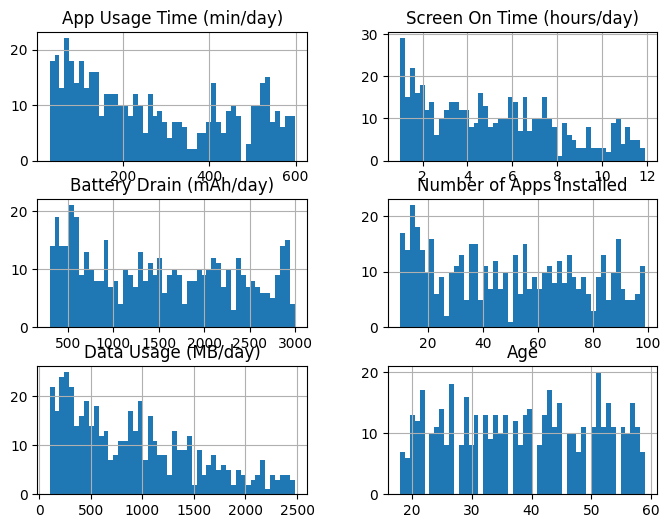

In [9]:
# Plot the histograms of the features, to get a sense of the distributions of the data
import matplotlib.pyplot as plt

X_train.hist(bins = 50, figsize = (8, 6))
plt.show()

Seems that some of the features are not uniform nor Gaussian (e.g. "Data Usage (MB/day)" seems to be more heavy-tailed), which is preferred by our models. We will perform a log transform on the feature to handle this. Plotting below some log-transformed features, to get a sense of what the data would look like.

<Axes: ylabel='Frequency'>

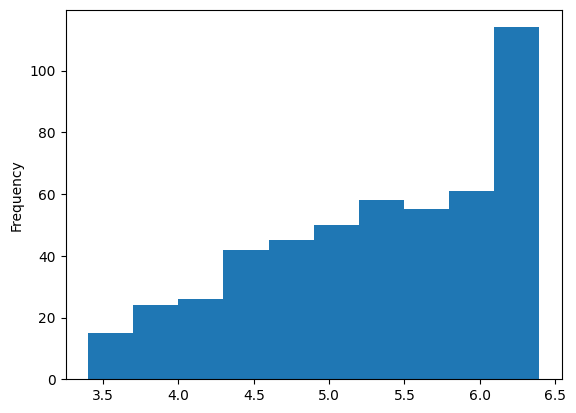

In [10]:
np.log(X_train["App Usage Time (min/day)"]).plot.hist()

<Axes: ylabel='Frequency'>

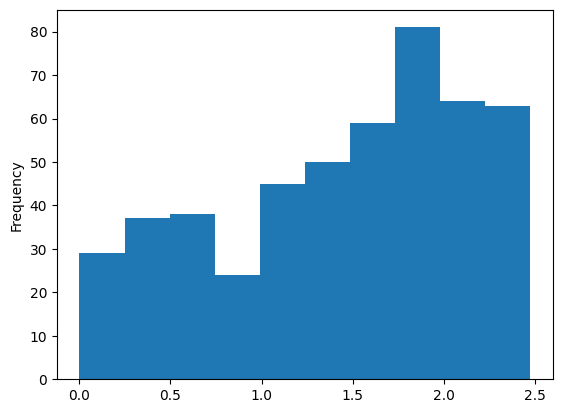

In [11]:
np.log(X_train["Screen On Time (hours/day)"]).plot.hist()

<Axes: ylabel='Frequency'>

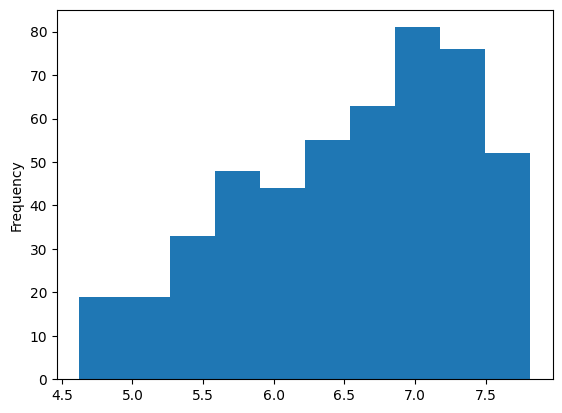

In [12]:
np.log(X_train["Data Usage (MB/day)"]).plot.hist()

In [13]:
# Identifying the integer, float, and categorical column names.
X_train_int_col = X_train.select_dtypes(include = ['int']).columns
X_train_float_col = X_train.select_dtypes(include = ['float']).columns
X_train_cat_col = X_train.select_dtypes(include = ['object']).columns

In [14]:
X_train[X_train_cat_col].value_counts()

Device Model        Operating System  Gender
Samsung Galaxy S21  Android           Male      55
Xiaomi Mi 11        Android           Female    55
iPhone 12           iOS               Female    52
Google Pixel 5      Android           Male      51
OnePlus 9           Android           Male      50
iPhone 12           iOS               Male      50
Google Pixel 5      Android           Female    48
Xiaomi Mi 11        Android           Male      48
OnePlus 9           Android           Female    43
Samsung Galaxy S21  Android           Female    38
Name: count, dtype: int64

# 2. Preprocessing Pipelines

We will perform:
1. Ordinal and OneHot Encoding for categorical features,
2. Standardize integer and float features, and
3. Apply a log transform on certain features that are skewed/heavy-tailed.

In [15]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer

ordinal_encoder = OrdinalEncoder()
oh_encoder = OneHotEncoder()
std_scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)

In [16]:
# Create several pipelines, and bundle them together via a ColumnTransformer preprocessor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer


log_pipeline = make_pipeline(
    log_transformer,
    std_scaler)

cat_pipeline = make_pipeline(
    ordinal_encoder,
    oh_encoder)

preprocessing = ColumnTransformer([
    ("int", std_scaler, ["App Usage Time (min/day)", "Battery Drain (mAh/day)", "Number of Apps Installed", "Age"]),
    ("log", log_pipeline, ["Screen On Time (hours/day)", "Data Usage (MB/day)"]),
    ("cat", cat_pipeline, X_train_cat_col),
])

# 3. Model Selection and Training
In this notebook, we will use the Random Forest Classifier algo to fit the data. Parameters for the RF classifiers are arbitrarily selected. We'll see if fine-tuning is required.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 50, max_leaf_nodes = 4, n_jobs = -1)

rf_pipeline = make_pipeline(
    preprocessing,
    rf_clf
)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  ['App Usage Time (min/day)',
                                                   'Battery Drain (mAh/day)',
                                                   'Number of Apps Installed',
                                                   'Age']),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Screen On Time (hours/day)',
                                                   'Data Usage (MB/day)']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['Device Model', 'Operating System', 'Gender'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_leaf_nodes=4, n_estimators=50,
                                        n_jobs=-1))])

In [18]:
y_test_pred_rf = rf_pipeline.predict(X_test)

# 4. Evaluating Model Performance

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred_rf)
cm

array([[41,  0,  0,  0,  0],
       [ 0, 39,  0,  0,  0],
       [ 0,  0, 45,  0,  0],
       [ 0,  0,  0, 39,  0],
       [ 0,  0,  0,  0, 46]])

In [20]:
# Precision, Recall, F1 scores
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: " + precision_score(y_test, y_test_pred_rf, average = 'micro').astype(str))
print("Recall: " + recall_score(y_test, y_test_pred_rf, average = 'micro').astype(str))
print("F1 score: " + f1_score(y_test, y_test_pred_rf, average = 'micro').astype(str))

Precision: 1.0
Recall: 1.0
F1 score: 1.0


In [21]:
# Cross Validation
from sklearn.model_selection import cross_val_score

cross_val_score(rf_pipeline, X_train, y_train, cv = 3, scoring = "accuracy")

array([1., 1., 1.])

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_auc_score

y_probas_rf = cross_val_predict(rf_pipeline, X_train, y_train, cv = 3, method = "predict_proba")
y_scores_rf = y_probas_rf[:, 1]
roc_auc_score(y_train, y_probas_rf, average = 'macro', multi_class = 'ovo', labels = [1, 2, 3, 4, 5])

1.0

In [23]:
# Print feature importance, to see which are the most important features in identifying the User Behavior Class
for score, name in zip(rf_clf.feature_importances_, X_train.columns):
    print(round(score, 2), name)

0.22 Device Model
0.17 Operating System
0.21 App Usage Time (min/day)
0.01 Screen On Time (hours/day)
0.16 Battery Drain (mAh/day)
0.22 Number of Apps Installed
0.0 Data Usage (MB/day)
0.0 Age
0.0 Gender


**Conclusion**: It seems that RF is really effective in this case, even by just using 70% of the original data for training.